# 🧠 CGT-GW: Contrastive Geometric Transfer via Gromov–WassersteinTraining Experiment

**Main training script for the CGT-GW proof-of-concept.**

Este notebook implementa o protocolo de treino em três fases:
1. **Alignment Phase**: Match Euclidean teacher structure via GW
2. **Refinement Phase**: Task-specific learning with soft alignment  
3. **Geometric Phase**: Full topological regularization

---

In [1]:
# @title 1. Setup Environment
!pip install -q sentence-transformers datasets scipy POT scikit-learn
import torch
print(f'PyTorch: {torch.__version__}')
print(f'CUDA: {torch.cuda.is_available()}')
if torch.cuda.is_available(): print(f'GPU: {torch.cuda.get_device_name(0)}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.3 MB/s eta 0:00:00
PyTorch: 2.9.0+cu126
CUDA: True
GPU: Tesla T4


In [2]:
!pip install geoopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 6.3 MB/s eta 0:00:00


## 1. Setup & Imports

In [3]:
import os
import sys
import math
import logging
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Optional, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

# Add project root to path
project_root = Path().absolute().parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: /
PyTorch version: 2.9.0+cu126
CUDA available: True


In [38]:
# @title 2. Upload and Extract cgt_project_FINAL.zip
from google.colab import files
import zipfile, os
!rm -rf /content/cgt_project /content/checkpoints
print('Cleaned. Upload cgt_project_FINAL.zip:')
uploaded = files.upload()
for f in uploaded:
    if f.endswith('.zip'):
        with zipfile.ZipFile(f,'r') as z: z.extractall('/content')
        print(f'Extracted: {f}')
        os.remove(f)
# Verify
import os
if os.path.exists('/content/cgt_project/src/cgt/__init__.py'):
    print('✅ Structure OK: /content/cgt_project/src/cgt/')
else:
    print('❌ ERROR: Structure invalid')
    !find /content -name 'cgt_hardened.py' 2>/dev/null

Cleaned. Upload cgt_project_FINAL.zip:


Saving cgt_project_FINAL.zip to cgt_project_FINAL.zip
Extracted: cgt_project_FINAL.zip
✅ Structure OK: /content/cgt_project/src/cgt/


In [41]:
# @title 3. Add Project to Path and Import
import sys
import importlib

# Force clear ALL cached modules
mods_to_remove = [m for m in sys.modules.keys() if any(x in m for x in ['cgt', 'unified', 'ablations', 'benchmarks', 'analysis'])]
for mod in mods_to_remove:
    del sys.modules[mod]

# Remove old paths and add fresh ones
sys.path = [p for p in sys.path if 'cgt_project' not in p]
sys.path.insert(0, '/content/cgt_project/src')
sys.path.insert(1, '/content/cgt_project/experiments')

print(f'sys.path[0]: {sys.path[0]}')
print(f'sys.path[1]: {sys.path[1]}')

# Verify directory exists
import os
assert os.path.exists('/content/cgt_project/src/cgt/__init__.py'), "cgt package not found!"
print('✅ Package structure verified')

# Test imports
from cgt.models.cgt_hardened import CGTStudentHardened
from cgt.geometry.lorentz_hardened import LorentzSubstrateHardened, LorentzConfig
print('✅ Core imported')

print('✅ Analysis imported')

print('\n🎯 All imports successful!')

sys.path[0]: /content/cgt_project/src
sys.path[1]: /content/cgt_project/experiments
✅ Package structure verified
✅ Core imported
✅ Analysis imported

🎯 All imports successful!


In [6]:
# Import from CGT project modules
from cgt.geometry.lorentz_hardened import LorentzSubstrateHardened, LorentzConfig

# PSI Extensions - H-AKORN e H-NCA
from cgt.psi_extensions.binding import HyperbolicAKORN, HAKORNConfig, HAKORNLayer, PhaseCoherenceLoss
from cgt.psi_extensions.dynamics import HyperbolicNCA, HNCAConfig, HyperbolicNCAWrapper

# Transfer e Topology
from cgt.psi_extensions.transfer.gw_transfer import (
    entropic_gromov_wasserstein_loss,
    compute_euclidean_cost_matrix,
    compute_hyperbolic_cost_matrix,
)
from cgt.psi_extensions.topology.topological_field import (
    PersistenceLandscapeField,
    TopologicalConfig,
    create_topological_field,
    DifferentiableTopologicalLoss,
)

# Visualization
from cgt.psi_extensions.visualization.plotting import (
    plot_poincare_embedding,
    plot_training_curves,
    MetricsLogger,
)

print("✓ CGT modules imported successfully!")
print("  - LorentzSubstrateHardened, LorentzConfig (geometry)")
print("  - HyperbolicAKORN, HAKORNConfig, HAKORNLayer, PhaseCoherenceLoss (binding)")
print("  - HyperbolicNCA, HNCAConfig, HyperbolicNCAWrapper (dynamics)")
print("  - DifferentiableTopologicalLoss (topology)")


✓ CGT modules imported successfully!
  - LorentzSubstrateHardened, LorentzConfig (geometry)
  - HyperbolicAKORN, HAKORNConfig, HAKORNLayer, PhaseCoherenceLoss (binding)
  - HyperbolicNCA, HNCAConfig, HyperbolicNCAWrapper (dynamics)
  - DifferentiableTopologicalLoss (topology)


---
## 2. Experiment Configuration

In [7]:
@dataclass
class ExperimentConfig:
    """Experiment configuration for Toy Ψ-SLM."""
    # Data
    depth: int = 5
    branching: int = 2

    # Model architecture
    embed_dim: int = 16
    hidden_dim: int = 64
    curvature: float = 1.0
    coupling_strength: float = 1.0
    temperature: float = 0.5

    # Training
    epochs: int = 100
    lr: float = 0.01
    lambda_topo: float = 0.1
    lambda_gw: float = 0.05
    lambda_coherence: float = 0.01
    num_nca_steps: int = 5

    # Misc
    seed: int = 42
    device: str = 'cuda'
    output_dir: str = '../outputs/toy_psi_slm'


# Create configuration
config = ExperimentConfig(
    depth=5,
    branching=2,
    epochs=100,
    embed_dim=16,
)

print("Experiment Configuration:")
print("=" * 40)
for field, value in vars(config).items():
    print(f"  {field}: {value}")

Experiment Configuration:
  depth: 5
  branching: 2
  embed_dim: 16
  hidden_dim: 64
  curvature: 1.0
  coupling_strength: 1.0
  temperature: 0.5
  epochs: 100
  lr: 0.01
  lambda_topo: 0.1
  lambda_gw: 0.05
  lambda_coherence: 0.01
  num_nca_steps: 5
  seed: 42
  device: cuda
  output_dir: ../outputs/toy_psi_slm


In [8]:
# Setup reproducibility and device
torch.manual_seed(config.seed)
np.random.seed(config.seed)

device = torch.device(config.device if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

os.makedirs(config.output_dir, exist_ok=True)
print(f"Output directory: {config.output_dir}")

Using device: cuda
Output directory: ../outputs/toy_psi_slm


---
## 3. Dataset Generation

In [9]:
@dataclass
class HierarchyDataset:
    """Container for synthetic hierarchy dataset."""
    graph: nx.Graph
    adjacency: torch.Tensor
    distance_matrix: torch.Tensor
    num_nodes: int
    depth: int
    branching_factor: int
    node_depths: torch.Tensor
    euclidean_embeddings: torch.Tensor


def generate_euclidean_tree_embedding(
    G: nx.Graph,
    embed_dim: int = 64,
    dtype: torch.dtype = torch.float64,
    device: Optional[torch.device] = None,
) -> torch.Tensor:
    """Generate Euclidean embeddings using spectral layout."""
    num_nodes = len(G.nodes)

    L = nx.laplacian_matrix(G).astype(np.float64)
    eigenvalues, eigenvectors = np.linalg.eigh(L.toarray())

    actual_dim = min(embed_dim, num_nodes - 1)
    embeddings = eigenvectors[:, 1:actual_dim + 1]

    if actual_dim < embed_dim:
        padding = np.zeros((num_nodes, embed_dim - actual_dim))
        embeddings = np.concatenate([embeddings, padding], axis=1)

    return torch.tensor(embeddings, dtype=dtype, device=device)


def generate_balanced_tree(
    depth: int = 10,
    branching_factor: int = 2,
    dtype: torch.dtype = torch.float64,
    device: Optional[torch.device] = None,
) -> HierarchyDataset:
    """Generate a balanced tree dataset."""
    G = nx.balanced_tree(branching_factor, depth)
    num_nodes = len(G.nodes)

    adj = nx.adjacency_matrix(G)
    adjacency = torch.tensor(adj.todense(), dtype=dtype, device=device)

    path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    distance_matrix = torch.zeros(num_nodes, num_nodes, dtype=dtype, device=device)

    nodes = list(G.nodes)
    for u in nodes:
        for v in nodes:
            distance_matrix[u, v] = path_lengths[u][v]

    depths_dict = nx.single_source_shortest_path_length(G, 0)
    node_depths = torch.tensor(
        [depths_dict[i] for i in range(num_nodes)],
        dtype=dtype, device=device
    )

    euclidean_dim = min(64, num_nodes)
    euclidean_embeddings = generate_euclidean_tree_embedding(
        G, embed_dim=euclidean_dim, dtype=dtype, device=device
    )

    return HierarchyDataset(
        graph=G,
        adjacency=adjacency,
        distance_matrix=distance_matrix,
        num_nodes=num_nodes,
        depth=depth,
        branching_factor=branching_factor,
        node_depths=node_depths,
        euclidean_embeddings=euclidean_embeddings,
    )


def get_dataset_info(dataset: HierarchyDataset) -> Dict:
    return {
        'num_nodes': dataset.num_nodes,
        'depth': dataset.depth,
        'branching_factor': dataset.branching_factor,
        'num_edges': dataset.graph.number_of_edges(),
        'max_distance': dataset.distance_matrix.max().item(),
        'mean_distance': dataset.distance_matrix.mean().item(),
        'node_depth_distribution': {
            int(d): (dataset.node_depths == d).sum().item()
            for d in torch.unique(dataset.node_depths)
        },
    }


print("✓ Dataset generation functions defined!")

✓ Dataset generation functions defined!


In [10]:
print(f"Generating balanced tree (depth={config.depth}, branching={config.branching})...")

dataset = generate_balanced_tree(
    depth=config.depth,
    branching_factor=config.branching,
    device=device,
)

info = get_dataset_info(dataset)

print(f"\nDataset Summary:")
print("=" * 40)
print(f"  Number of nodes: {info['num_nodes']}")
print(f"  Number of edges: {info['num_edges']}")
print(f"  Tree depth: {info['depth']}")
print(f"  Max distance: {info['max_distance']:.1f}")
print(f"\nNode depth distribution:")
for depth_level, count in sorted(info['node_depth_distribution'].items()):
    print(f"    Level {depth_level}: {count} nodes")

Generating balanced tree (depth=5, branching=2)...

Dataset Summary:
  Number of nodes: 63
  Number of edges: 62
  Tree depth: 5
  Max distance: 10.0

Node depth distribution:
    Level 0: 1 nodes
    Level 1: 2 nodes
    Level 2: 4 nodes
    Level 3: 8 nodes
    Level 4: 16 nodes
    Level 5: 32 nodes


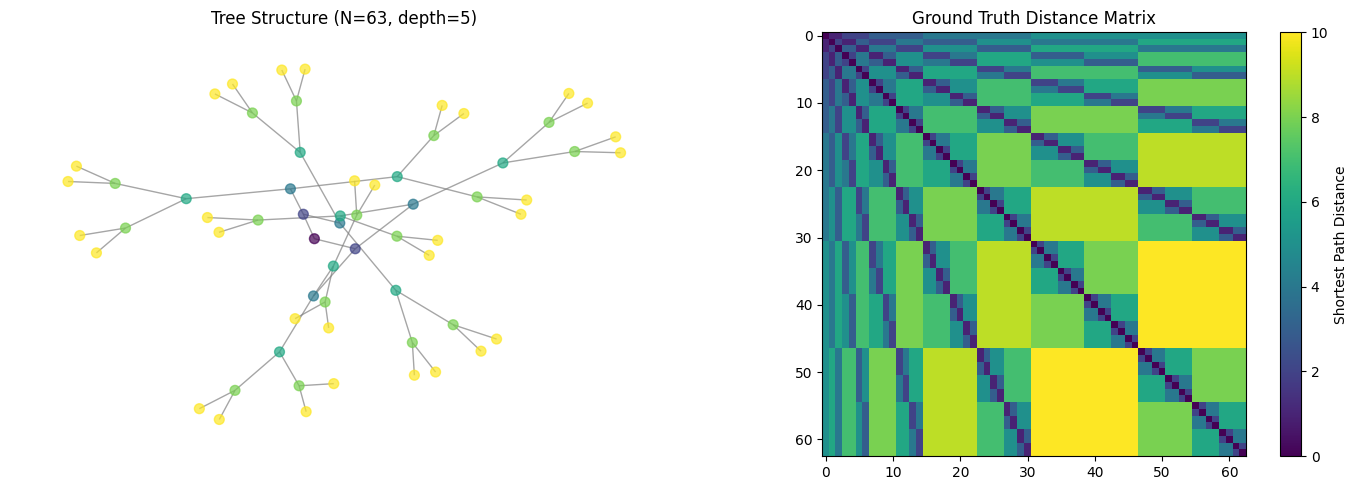

In [11]:
# Visualize the tree structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
pos = nx.spring_layout(dataset.graph, seed=42)
node_colors = dataset.node_depths.cpu().numpy()
nx.draw(dataset.graph, pos, ax=ax1, node_color=node_colors, cmap='viridis',
        node_size=50, with_labels=False, edge_color='gray', alpha=0.7)
ax1.set_title(f"Tree Structure (N={info['num_nodes']}, depth={info['depth']})")

ax2 = axes[1]
im = ax2.imshow(dataset.distance_matrix.cpu().numpy(), cmap='viridis')
plt.colorbar(im, ax=ax2, label='Shortest Path Distance')
ax2.set_title('Ground Truth Distance Matrix')

plt.tight_layout()
plt.show()

---
## 6. Topological Loss (using CGT's PersistenceLandscapeField)

In [12]:
# DifferentiableTopologicalLoss agora é importado de cgt.psi_extensions.topology
print("✓ DifferentiableTopologicalLoss importado de cgt_project")


✓ DifferentiableTopologicalLoss importado de cgt_project


In [13]:
# HyperbolicNCAWrapper agora é importado de cgt.psi_extensions.dynamics
print("✓ HyperbolicNCAWrapper importado de cgt_project")


✓ HyperbolicNCAWrapper importado de cgt_project


---
## 7. Metrics

In [14]:
def compute_distortion(
    h_states: torch.Tensor,
    target_distances: torch.Tensor,
    substrate: LorentzSubstrateHardened
) -> Dict[str, float]:
    """Compute embedding distortion metrics using CGT's substrate."""
    # Compute predicted distances using CGT's LorentzSubstrate
    pred_distances = substrate.distance_matrix(h_states)

    N = h_states.shape[0]
    mask = ~torch.eye(N, dtype=torch.bool, device=h_states.device)
    pred_flat = pred_distances[mask]
    target_flat = target_distances[mask]

    # Mean absolute error
    mae = torch.mean(torch.abs(pred_flat - target_flat)).item()

    # Mean relative error
    mre = torch.mean(torch.abs(pred_flat - target_flat) / (target_flat + 1e-8)).item()

    # Max distortion
    ratios = pred_flat / (target_flat + 1e-8)
    max_expansion = ratios.max().item()
    max_contraction = ratios.min().item()
    max_distortion = max(max_expansion, 1.0 / (max_contraction + 1e-8))

    # Spearman rank correlation
    pred_ranks = torch.argsort(torch.argsort(pred_flat)).float()
    target_ranks = torch.argsort(torch.argsort(target_flat)).float()
    n = pred_ranks.shape[0]
    d_sq = torch.sum((pred_ranks - target_ranks) ** 2)
    spearman = 1 - 6 * d_sq / (n * (n ** 2 - 1))

    return {
        'mean_absolute_error': mae,
        'mean_relative_error': mre,
        'max_distortion': max_distortion,
        'spearman_correlation': spearman.item(),
    }


print("✓ Distortion metrics defined!")

✓ Distortion metrics defined!


---
## 8. Stable Initialization

In [15]:
def stable_initialization(
    n_nodes: int,
    embed_dim: int,
    substrate: LorentzSubstrateHardened,
    r_start: float = 0.5,
) -> geoopt.ManifoldParameter:
    """
    Initialize hyperbolic states with geoopt ManifoldParameter.

    Uses CGT's LorentzSubstrate for exp_map.
    """
    K = substrate.K.item() if isinstance(substrate.K, torch.Tensor) else substrate.K
    manifold = geoopt.Lorentz(k=K)

    # Initialize in tangent space at origin
    v = torch.randn(n_nodes, embed_dim, dtype=torch.float64)
    v = v * r_start / (torch.norm(v, dim=-1, keepdim=True) + 1e-8)

    # Construct tangent vector at origin (time component = 0)
    v_full = torch.zeros(n_nodes, embed_dim + 1, dtype=torch.float64)
    v_full[:, 1:] = v

    # Get origin and exp map
    origin = substrate.origin(n_nodes)
    v_full = v_full.to(origin.device)

    # Project to tangent space and then to manifold
    v_tangent = substrate.riemannian_grad(origin, v_full)
    x = substrate.exp_map(origin, v_tangent)

    return geoopt.ManifoldParameter(x, manifold=manifold)


print("✓ Stable initialization defined!")

✓ Stable initialization defined!


---
## 9. Complete ToyPsiSLM Model

In [27]:
class CGTGW(nn.Module):
    """
    Complete Toy Ψ-SLM model using CGT's LorentzSubstrateHardened.

    Architecture:
    - h_states: Learned initial embeddings (optimized via gradient descent)
    - h_nca: Learned dynamics operator
    - h_akorn: Phase synchronization for binding

    The optimizer updates h_states based on loss gradients.
    NO manual state updates during forward pass.
    """

    def __init__(
        self,
        num_nodes: int,
        embed_dim: int = 16,
        hidden_dim: int = 64,
        coupling_strength: float = 1.0,
        temperature: float = 0.5,
        curvature: float = 1.0,
    ):
        super().__init__()

        # CGT's Lorentz substrate (hardened version)
        lorentz_config = LorentzConfig(
            intrinsic_dim=embed_dim,
            initial_curvature=curvature,
            learnable_curvature=False,
        )
        self.substrate = LorentzSubstrateHardened(config=lorentz_config)

        # Initialize hyperbolic states (learned initial conditions)
        self.h_states = stable_initialization(
            n_nodes=num_nodes,
            embed_dim=embed_dim,
            substrate=self.substrate,
            r_start=0.5,
        )

        # H-NCA layer (learned dynamics)
        self.h_nca = HyperbolicNCAWrapper(
            substrate=self.substrate,
            embed_dim=embed_dim,
            hidden_dim=hidden_dim,
        )

        # H-AKORN layer (phase binding)
        self.h_akorn = HAKORNLayer(
            num_nodes=num_nodes,
            coupling_strength=coupling_strength,
            temperature=temperature,
        )

        # Loss modules
        self.topo_loss = DifferentiableTopologicalLoss(substrate=self.substrate)
        self.coherence_loss = PhaseCoherenceLoss(critical_threshold=0.3)

        self.num_nodes = num_nodes
        self.embed_dim = embed_dim

    def forward(
        self,
        adjacency: torch.Tensor,
        num_steps: int = 1,
    ) -> Dict[str, torch.Tensor]:
        # Start from learned initial states
        # No clone needed - gradient flows through h_states directly
        h = self.h_states

        # Run dynamics
        modulation_weights = None
        order_param = torch.tensor(0.0, device=h.device, dtype=h.dtype)

        for _ in range(num_steps):
            modulation_weights, order_param = self.h_akorn(h, self.substrate, adjacency)
            h = self.h_nca(h, adjacency, modulation_weights)

        # NO manual state update - optimizer handles h_states via gradients

        return {
            'states': h,
            'modulation_weights': modulation_weights,
            'order_parameter': order_param,
        }

    def compute_losses(
        self,
        outputs: Dict[str, torch.Tensor],
        target_distances: torch.Tensor,
        source_embeddings: Optional[torch.Tensor] = None,
        lambda_topo: float = 0.1,
        lambda_gw: float = 0.05,
        lambda_coherence: float = 0.01,
    ) -> Dict[str, torch.Tensor]:
        h = outputs['states']
        order_param = outputs['order_parameter']

        # Task loss: distance preservation
        pred_distances = self.substrate.distance_matrix(h)
        pred_distances = torch.nan_to_num(pred_distances, nan=0.0, posinf=0.0, neginf=0.0)

        # Detach max to avoid scale gradients dominating geometry
        pred_max = pred_distances.max().detach()
        target_max = target_distances.max()

        # Safe normalization
        if pred_max > 1e-8:
            pred_norm = pred_distances / (pred_max + 1e-8)
        else:
            pred_norm = pred_distances

        if target_max > 1e-8:
            target_norm = target_distances / (target_max + 1e-8)
        else:
            target_norm = target_distances

        task_loss = torch.mean((pred_norm - target_norm) ** 2)

        # Topological loss
        if lambda_topo > 0:
            topo_loss = self.topo_loss(h)
        else:
            topo_loss = torch.tensor(0.0, device=h.device, dtype=h.dtype)

        # GW alignment loss
        if source_embeddings is not None and lambda_gw > 0:
            gw_loss = entropic_gromov_wasserstein_loss(
                source_embeddings.to(h.dtype), h, self.substrate
            )
        else:
            gw_loss = torch.tensor(0.0, device=h.device, dtype=h.dtype)

        # Coherence loss
        if torch.isfinite(order_param):
            coh_loss = self.coherence_loss(order_param)
        else:
            coh_loss = torch.tensor(0.0, device=h.device, dtype=h.dtype)

        # Total loss
        total = (task_loss
                 + lambda_topo * topo_loss
                 + lambda_gw * gw_loss
                 + lambda_coherence * coh_loss)

        # NaN protection - convert to zero but keep differentiable
        total = torch.nan_to_num(total, nan=0.0, posinf=0.0, neginf=0.0)

        return {
            'total': total,
            'task': task_loss,
            'topo': topo_loss,
            'gw': gw_loss,
            'coherence': coh_loss,
            'order_param': order_param,
        }


print("✓ ToyPsiSLM model defined (clean gradient flow)!")


✓ ToyPsiSLM model defined (clean gradient flow)!


---
## 10. Training Function

In [28]:
def train_epoch(
    model: CGTGW,
    optimizer: geoopt.optim.RiemannianAdam,
    adjacency: torch.Tensor,
    target_distances: torch.Tensor,
    source_embeddings: Optional[torch.Tensor],
    lambda_topo: float,
    lambda_gw: float,
    num_steps: int = 5,
) -> Dict[str, float]:
    """Train for one epoch."""
    model.train()
    optimizer.zero_grad()

    outputs = model(adjacency, num_steps=num_steps)

    losses = model.compute_losses(
        outputs,
        target_distances,
        source_embeddings,
        lambda_topo=lambda_topo,
        lambda_gw=lambda_gw,
    )

    losses['total'].backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    return {
        'total_loss': losses['total'].item(),
        'task_loss': losses['task'].item(),
        'topo_loss': losses['topo'].item(),
        'gw_loss': losses['gw'].item(),
        'coherence_loss': losses['coherence'].item(),
        'order_param': losses['order_param'].item(),
    }


print("✓ Training function defined!")

✓ Training function defined!


---
## 11. Initialize Model

In [29]:
print(f"Creating Toy Ψ-SLM model with CGT's LorentzSubstrate...")

model = CGTGW(
    num_nodes=dataset.num_nodes,
    embed_dim=config.embed_dim,
    hidden_dim=config.hidden_dim,
    coupling_strength=config.coupling_strength,
    temperature=config.temperature,
    curvature=config.curvature,
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Summary:")
print("=" * 40)
print(f"  Total parameters: {total_params:,}")
print(f"  Embedding dimension: {config.embed_dim}")
print(f"  Curvature K: {model.substrate.K.item():.4f}")

optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=config.lr)
print(f"\nOptimizer: RiemannianAdam (lr={config.lr})")

Creating Toy Ψ-SLM model with CGT's LorentzSubstrate...

Model Summary:
  Total parameters: 7,363
  Embedding dimension: 16
  Curvature K: 1.0000

Optimizer: RiemannianAdam (lr=0.01)


---
## 12. Training Loop

In [30]:
logger = MetricsLogger()

phase1_end = config.epochs // 3
phase2_end = 2 * config.epochs // 3

print(f"Training Schedule:")
print("=" * 40)
print(f"  Phase 1 (Alignment): epochs 0-{phase1_end-1}")
print(f"  Phase 2 (Refinement): epochs {phase1_end}-{phase2_end-1}")
print(f"  Phase 3 (Geometric): epochs {phase2_end}-{config.epochs-1}")

Training Schedule:
  Phase 1 (Alignment): epochs 0-32
  Phase 2 (Refinement): epochs 33-65
  Phase 3 (Geometric): epochs 66-99


In [31]:
print(f"\nStarting training for {config.epochs} epochs...")
print("=" * 60)

for epoch in tqdm(range(config.epochs), desc="Training"):
    if epoch < phase1_end:
        lambda_topo = 0.0
        lambda_gw = 0.1
        phase = "Alignment"
    elif epoch < phase2_end:
        lambda_topo = 0.05
        lambda_gw = 0.05
        phase = "Refinement"
    else:
        lambda_topo = config.lambda_topo
        lambda_gw = 0.01
        phase = "Geometric"

    metrics = train_epoch(
        model=model,
        optimizer=optimizer,
        adjacency=dataset.adjacency,
        target_distances=dataset.distance_matrix,
        source_embeddings=dataset.euclidean_embeddings,
        lambda_topo=lambda_topo,
        lambda_gw=lambda_gw,
        num_steps=config.num_nca_steps,
    )

    metrics['phase'] = ['Alignment', 'Refinement', 'Geometric'].index(phase)
    metrics['lambda_topo'] = lambda_topo
    metrics['lambda_gw'] = lambda_gw

    logger.log(metrics)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:3d} [{phase:10s}]: "
            f"total={metrics['total_loss']:.4f}, "
            f"task={metrics['task_loss']:.4f}, "
            f"topo={metrics['topo_loss']:.4f}, "
            f"Γ={metrics['order_param']:.3f}"
        )

print("\n" + "=" * 60)
print("Training Complete!")


Starting training for 100 epochs...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch  10 [Alignment ]: total=0.0669, task=0.0480, topo=0.0000, Γ=0.202
Epoch  20 [Alignment ]: total=0.1397, task=0.1342, topo=0.0000, Γ=0.296
Epoch  30 [Alignment ]: total=0.0832, task=0.0709, topo=0.0000, Γ=0.355
Epoch  40 [Refinement]: total=0.2515, task=0.0861, topo=2.9918, Γ=0.417
Epoch  50 [Refinement]: total=0.1833, task=0.0495, topo=2.4957, Γ=0.479
Epoch  60 [Refinement]: total=0.1814, task=0.0506, topo=2.4964, Γ=0.530
Epoch  70 [Geometric ]: total=0.2378, task=0.0531, topo=1.8368, Γ=0.576
Epoch  80 [Geometric ]: total=0.1797, task=0.0589, topo=1.1991, Γ=0.616
Epoch  90 [Geometric ]: total=0.2486, task=0.0619, topo=1.8594, Γ=0.653
Epoch 100 [Geometric ]: total=0.1814, task=0.0624, topo=1.1823, Γ=0.684

Training Complete!


---
## 13. Evaluation

In [32]:
print("\nFinal Evaluation")
print("=" * 50)

model.eval()
with torch.no_grad():
    outputs = model(dataset.adjacency, num_steps=1)
    final_states = outputs['states']

    # Ensure states are on manifold and finite
    final_states = model.substrate.proj(final_states)

    # Check for NaN/Inf
    if not torch.isfinite(final_states).all():
        print("⚠️ Warning: Final states contain NaN/Inf values!")
        print(f"   NaN count: {torch.isnan(final_states).sum().item()}")
        print(f"   Inf count: {torch.isinf(final_states).sum().item()}")
        # Replace NaN/Inf for evaluation
        final_states = torch.nan_to_num(final_states, nan=0.0, posinf=1e6, neginf=-1e6)
        final_states = model.substrate.proj(final_states)

    distortion = compute_distortion(
        final_states,
        dataset.distance_matrix,
        model.substrate,
    )

    # Check manifold constraint
    manifold_violation = model.substrate.manifold_violation(final_states)

    print(f"\nDistortion Metrics:")
    print(f"  Mean Absolute Error: {distortion['mean_absolute_error']:.4f}")
    print(f"  Mean Relative Error: {distortion['mean_relative_error']:.4f}")
    print(f"  Max Distortion: {distortion['max_distortion']:.4f}")
    print(f"  Spearman Correlation: {distortion['spearman_correlation']:.4f}")
    print(f"  Order Parameter (Γ): {outputs['order_parameter']:.4f}")
    print(f"  Manifold Violation: {manifold_violation:.2e}")



Final Evaluation

Distortion Metrics:
  Mean Absolute Error: 5.7808
  Mean Relative Error: 0.8463
  Max Distortion: 17.1424
  Spearman Correlation: 0.5765
  Order Parameter (Γ): 0.6853
  Manifold Violation: 1.00e-06


---
## 14. Visualizations

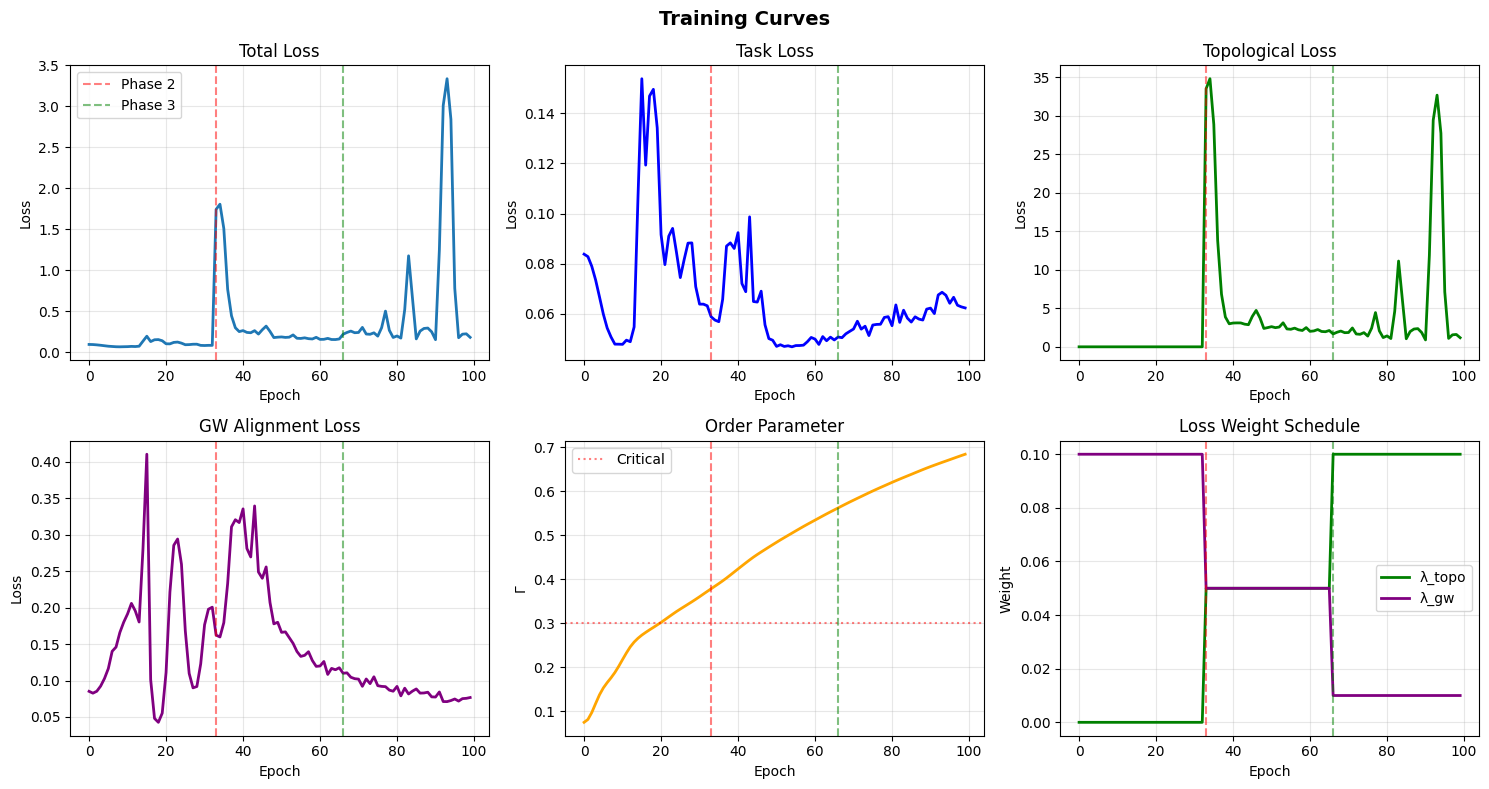

In [33]:
# Training curves
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

ax = axes[0, 0]
ax.plot(logger.history['total_loss'], linewidth=2)
ax.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.5, label='Phase 2')
ax.axvline(x=phase2_end, color='g', linestyle='--', alpha=0.5, label='Phase 3')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Total Loss')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(logger.history['task_loss'], linewidth=2, color='blue')
ax.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.5)
ax.axvline(x=phase2_end, color='g', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Task Loss')
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.plot(logger.history['topo_loss'], linewidth=2, color='green')
ax.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.5)
ax.axvline(x=phase2_end, color='g', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Topological Loss')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(logger.history['gw_loss'], linewidth=2, color='purple')
ax.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.5)
ax.axvline(x=phase2_end, color='g', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('GW Alignment Loss')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(logger.history['order_param'], linewidth=2, color='orange')
ax.axhline(y=0.3, color='r', linestyle=':', alpha=0.5, label='Critical')
ax.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.5)
ax.axvline(x=phase2_end, color='g', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Γ')
ax.set_title('Order Parameter')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.plot(logger.history['lambda_topo'], linewidth=2, label='λ_topo', color='green')
ax.plot(logger.history['lambda_gw'], linewidth=2, label='λ_gw', color='purple')
ax.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.5)
ax.axvline(x=phase2_end, color='g', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Weight')
ax.set_title('Loss Weight Schedule')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, 'training_curves.png'), dpi=150)
plt.show()

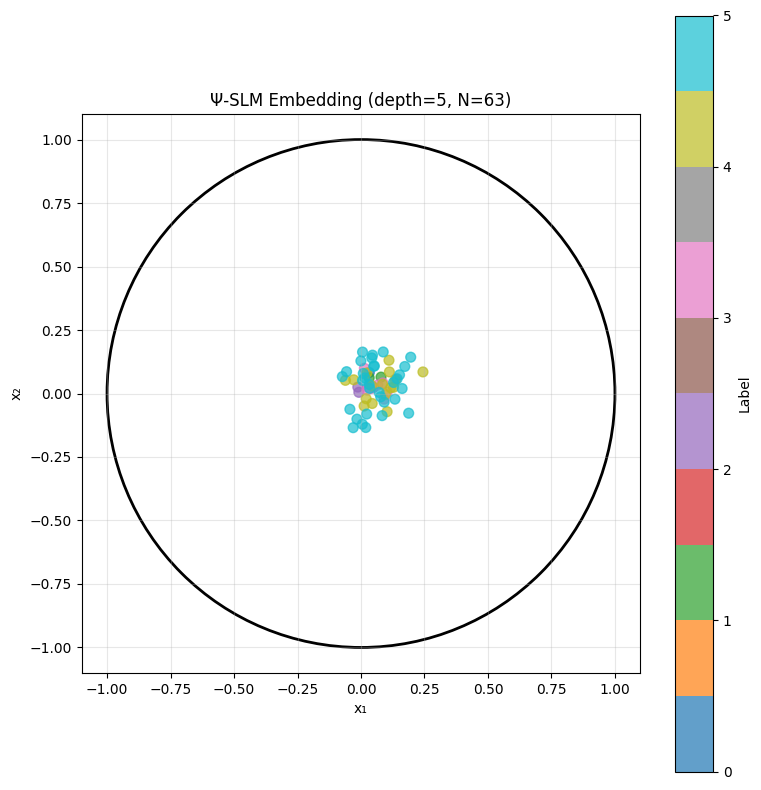

In [34]:
# Poincaré disk embedding using CGT's visualization
fig = plot_poincare_embedding(
    final_states,
    model.substrate,
    labels=dataset.node_depths,
    title=f"Ψ-SLM Embedding (depth={config.depth}, N={dataset.num_nodes})",
    save_path=os.path.join(config.output_dir, 'poincare_embedding.png'),
)
plt.show()

Lorentz plot saved to: ../outputs/toy_psi_slm/lorentz_3d.png


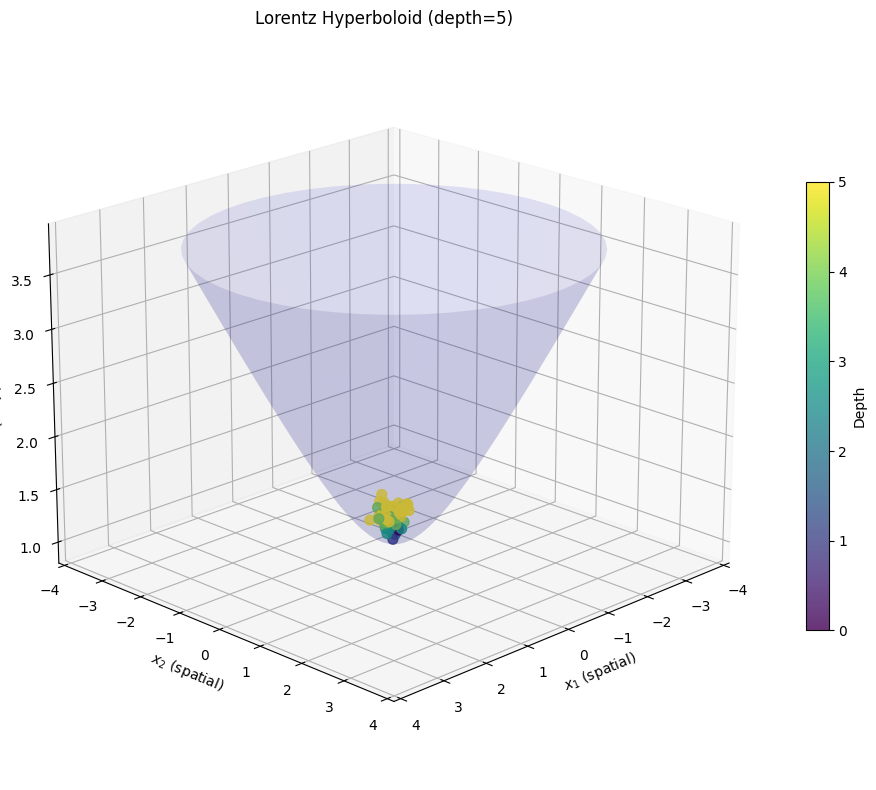

In [42]:
from cgt.psi_extensions.visualization import plot_lorentz_embedding

fig = plot_lorentz_embedding(
    final_states,
    model.substrate,
    labels=dataset.node_depths,
    title=f"Lorentz Hyperboloid (depth={config.depth})",
    save_path=os.path.join(config.output_dir, 'lorentz_3d.png'),
    elev=20,  # ângulo de elevação
    azim=45,  # ângulo azimutal
)
plt.show()

Lorentz 2D plot saved to: ../outputs/toy_psi_slm/lorentz_2d.png


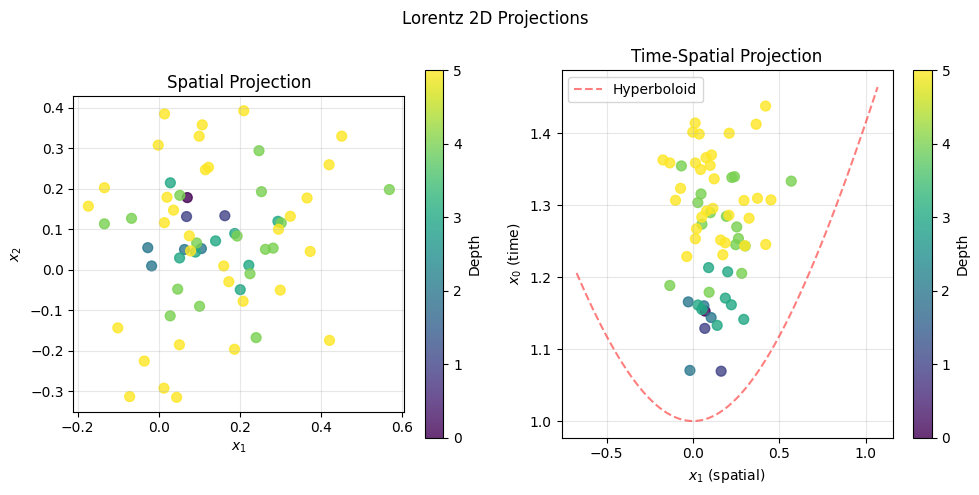

In [43]:
from cgt.psi_extensions.visualization import plot_lorentz_2d_projection

fig = plot_lorentz_2d_projection(
    final_states,
    model.substrate,
    labels=dataset.node_depths,
    title=f"Lorentz 2D Projections",
    save_path=os.path.join(config.output_dir, 'lorentz_2d.png'),
)
plt.show()

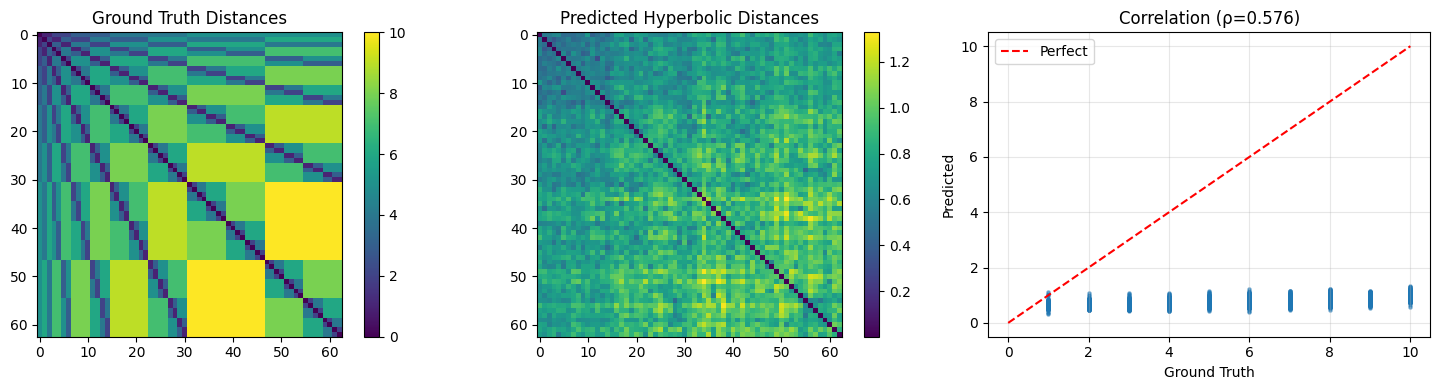

In [35]:
# Distance comparison
with torch.no_grad():
    pred_distances = model.substrate.distance_matrix(final_states)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
im = ax.imshow(dataset.distance_matrix.cpu().numpy(), cmap='viridis')
plt.colorbar(im, ax=ax)
ax.set_title('Ground Truth Distances')

ax = axes[1]
im = ax.imshow(pred_distances.cpu().numpy(), cmap='viridis')
plt.colorbar(im, ax=ax)
ax.set_title('Predicted Hyperbolic Distances')

ax = axes[2]
N = final_states.shape[0]
mask = ~torch.eye(N, dtype=torch.bool, device=device)
gt_flat = dataset.distance_matrix[mask].cpu().numpy()
pred_flat = pred_distances[mask].cpu().numpy()
ax.scatter(gt_flat, pred_flat, alpha=0.3, s=5)
ax.plot([0, gt_flat.max()], [0, gt_flat.max()], 'r--', label='Perfect')
ax.set_xlabel('Ground Truth')
ax.set_ylabel('Predicted')
ax.set_title(f'Correlation (ρ={distortion["spearman_correlation"]:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, 'distance_comparison.png'), dpi=150)
plt.show()

---
## 15. Save Model

In [36]:
checkpoint_path = os.path.join(config.output_dir, 'model_checkpoint.pt')

torch.save({
    'model_state_dict': model.state_dict(),
    'config': vars(config),
    'metrics': logger.history,
    'distortion': distortion,
    'final_order_param': outputs['order_parameter'].item(),
    'curvature': model.substrate.K.item(),
}, checkpoint_path)

print(f"Model saved to: {checkpoint_path}")

Model saved to: ../outputs/toy_psi_slm/model_checkpoint.pt


In [37]:
print("\n" + "=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)

print(f"\nConfiguration:")
print(f"  Tree: depth={config.depth}, branching={config.branching}")
print(f"  Nodes: {dataset.num_nodes}")
print(f"  Embedding dim: {config.embed_dim}")
print(f"  Epochs: {config.epochs}")

print(f"\nFinal Metrics:")
print(f"  Task Loss: {logger.history['task_loss'][-1]:.4f}")
print(f"  Topo Loss: {logger.history['topo_loss'][-1]:.4f}")
print(f"  Order Parameter: {logger.history['order_param'][-1]:.4f}")

print(f"\nDistortion Metrics:")
print(f"  MAE: {distortion['mean_absolute_error']:.4f}")
print(f"  MRE: {distortion['mean_relative_error']:.4f}")
print(f"  Spearman ρ: {distortion['spearman_correlation']:.4f}")

print(f"\nCGT Substrate Info:")
print(f"  Curvature K: {model.substrate.K.item():.4f}")
print(f"  Manifold Violation: {manifold_violation:.2e}")

print(f"\nOutputs saved to: {config.output_dir}")
print("=" * 60)
print("Done!")


EXPERIMENT SUMMARY

Configuration:
  Tree: depth=5, branching=2
  Nodes: 63
  Embedding dim: 16
  Epochs: 100

Final Metrics:
  Task Loss: 0.0624
  Topo Loss: 1.1823
  Order Parameter: 0.6843

Distortion Metrics:
  MAE: 5.7808
  MRE: 0.8463
  Spearman ρ: 0.5765

CGT Substrate Info:
  Curvature K: 1.0000
  Manifold Violation: 1.00e-06

Outputs saved to: ../outputs/toy_psi_slm
Done!
